# LSST Solar System Processing

## Linking of Observations from JPL Veres & Chesley dataset via HelioLinC

### Algorithm: 

Based on HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
A tracklet + velocity vector is called an "arrow". 
Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.

### Implementation:
S. Eggl 20191215
    

In [1]:
# Solar System Processing functions
import lsstssp as ls

/data/epyc/projects/lsst_ssp/thor/thor/orbits/kepler.py:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  e_vec = ((v_mag**2 - mu / r_mag) * r - (np.dot(r, v)) * v) / mu
/data/epyc/projects/lsst_ssp/thor/thor/orbits/kepler.py:79: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  trueAnom_deg = np.degrees(np.arccos(np.dot(e_vec, r) / (e * r_mag)))
/data/epyc/projects/lsst_ssp/thor/thor/orbits/kepler.py:80: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  if np.dot(r, v) < 0:
/data/epyc/projects/lsst_ssp/thor/thor/orbits/propagate/universal.py:46: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  rv_mag = np.dot(r, v) / r_mag


In [2]:
import constants as cnst
import vector as vec
import transforms as tr
import propagate as prop
import ephemeris as ephem
import state as st

In [3]:
from thor.orbits import iod

In [4]:
# Gauss method for initial orbit determination
#import gauss2 as iod

In [5]:
#Accelerators
import numpy as np
#import numba
from joblib import Parallel, delayed

#Database
import pandas as pd
import sqlite3 as sql

# # External API's
# from astroquery.jplhorizons import Horizons
from astroquery.jplsbdb import SBDB

#Orbital Dynamics
import spiceypy as sp

#Interpolation
import scipy.interpolate as spi

# Clustering
import scipy.spatial as scsp
import sklearn.cluster as cluster

#Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

import plotly.graph_objects as go
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}

#Timing
import time
#%matplotlib inline

from datetime import datetime
from tqdm import tqdm


/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [6]:
jpl_data_path="/data/epyc/data/solarsystem/jpl/fullDensity_3months/jpl_fullDensity.db"

def grab_JPL_data(database,nrows, query="""SELECT * FROM detections LIMIT """):
    """Import JPL LSST Veres & Chesley dataset from local database
    
    Parameters:
    -----------
    database ... path to database
    nrows ... number of rows 
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql(query+str(nrows), con)
    
    return observations


def grab_n_nights_of_JPL_data(database,tstart,tend):
    """Import JPL LSST Veres & Chesley dataset from local database
    
    Parameters:
    -----------
    database ... path to database
    tstart ... start night: number of nights since start of LSST survey (kraken2026) 
    tend ... last night: number of nights since start 
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    t0=52390
    
    if (tstart>tend):
        print('Start night must be before end night! ')
    
    else:
        qnights="nn <= " + str(t0+tend) + " AND nn >= " + str(t0+tstart)
        print(qnights)
        con = sql.connect(database)
        observations = pd.read_sql("""SELECT * FROM detections WHERE """+qnights, con)
    
    return observations


def grab_n_nights_of_JPL_data_in_field(database, tstart, tend, ramin, ramax, decmin, decmax):
    """Import JPL LSST Veres & Chesley dataset from local database
    
    Parameters:
    -----------
    database ... path to database
    tstart ... start night: number of nights since start of LSST survey (kraken2026) 
    tend ... last night: number of nights since start 
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    t0=52390
    
    if (tstart>tend):
        print('Start night must be before end night! ')
    
    else:
        qnights="nn <= " + str(t0+tend) + " AND nn >= " + str(t0+tstart)
        print(qnights)
        box=(" AND ra_deg >= " + str(ramin) + " AND ra_deg <= " +str(ramax) + 
             " AND dec_deg >= " + str(decmin) + " AND dec_deg <= " + str(decmax))
        
        con = sql.connect(database)
        observations = pd.read_sql("""SELECT * FROM detections WHERE """+qnights+box, con)
    
    return observations


In [9]:
def plot_clusters(data, algorithm, args, kwds):
    """Cluster and plot data with skit learn algorithm """
    #start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    plt.figure(dpi=300)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [10]:
def plot_clusters3d(data, dims, algorithm, args, kwds):
    """Cluster and plot multi dimensional data with skit learn algorithm
        Plotting is done in 3D only,"""
    #start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    fig=plt.figure(dpi=300,figsize=(20,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(data.T[dims[0]], data.T[dims[1]], data.T[dims[2]], c=colors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=22)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=10)

In [11]:
def plot_orbits3d(df, xlims, ylims, zlims):
    """Orbit plot in 3D,"""
    palette = sns.color_palette('deep', np.unique(df['objId']).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in df['objId']]
    
    fig=plt.figure(dpi=300,figsize=(20,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(df['x'], df['y'], df['z'], c=colors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    frame = plt.gca()

    if(xlims != []):
        ax.set_xlim(xlims[0],xlims[1])
    if(ylims != []):
        ax.set_ylim(ylims[0],ylims[1])
    if(zlims != []):
        ax.set_zlim(zlims[0],zlims[1])    
    
    plt.title('Orbits', fontsize=22)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=10)

In [12]:
def plot_positions3d(t,x,y,z,*args,**kwargs):
    """Plot x,y,z positions in 3D with color coding (time).
    
    Parameters:
    -----------
    t ... time array
    x ... array containing x coordinates
    y ... array containing t coordinates
    z ... array containing z coordinates
    
    Kwargs:
    -------
    xlim, ylim, zlim ... [min,max] ranges for x,y and z axes
    """
#t = dt[:]
#x, y, z = xp[:,0], xp[:,1], xp[:,2]

    options = {'xlim' : [], 'ylim' : [] }

    options.update(kwargs)

    data=[go.Scatter3d(x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=3,
            color=t,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
                    ))]

    layout = go.Layout(
        xaxis=dict(range=options['xlim']),
        yaxis=dict(range=options['ylim'])
 #       zaxis=dict(range=options['zlim'])
                  )

    fig = go.Figure(data=data, layout=layout)

# tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [14]:
def correct_pairs(df,pairs):
    """Which pairs are actually good, i.e. which tracklets are real?
    
    Parameters:
    -----------
    df      ... pandas dataframe with observations
    pairs   ... list of pairs of observations [obsid1,obsid2] linked into arrows
    
    Returns:
    --------
    correct ... logical array (dimension of pairs[:,0])
    """
    p=np.array(pairs)
    #find out which pairs are actually good
    pair_obj=np.array([df['objId'][p[:,0]].values,df['objId'][p[:,1]].values]).T
    #print(pair_obj)
    #correct=np.where(df['obj'][p[:,0]].values == df['obj'][p[:,1]].values)
    correct=np.where(pair_obj[:,0] == pair_obj[:,1])
    return correct[0]

In [15]:
def observations_in_cluster(df,pairs,cluster, garbage=False):
    """List observations in each cluster.
    
    Parameters:
    -----------
    df      ... pandas dataframe with observations
    pairs   ... list of pairs of observations [obsid1,obsid2] linked into arrows
    cluster ... output of clustering algorithm (sklearn.cluster)
    
    Returns:
    --------
    obs_in_cluster ... list of observations in each cluster
    """
    #cluster names (beware: -1 is the cluster of all the leftovers)
    if(garbage):
        unique_labels = np.unique(cluster.labels_)
    else:
        unique_labels = np.unique(cluster.labels_)[1:]
    #number of clusters
    n_clusters = len(unique_labels)
    
    #which objects do observations in pairs (tracklets) belong to
    p = np.array(pairs)              
    
    obs_in_cluster=[]
    obs_in_cluster_add=obs_in_cluster.append
    
    #cluster contains 
    for u in unique_labels:
        #which indices in pair array appear in a given cluster?
        idx = np.where(cluster.labels_ == u)[0]
        
        #which observations are in this cluster
        obs_in_cluster_add(np.unique(p[idx].flatten()))
    
    return obs_in_cluster, unique_labels

In [16]:
def objects_in_cluster(df,pairs,cluster):
    """List observations in each cluster.
    
    Parameters:
    -----------
    df      ... pandas dataframe with observations
    pairs   ... list of pairs of observations [obsid1,obsid2] linked into arrows
    cluster ... output of clustering algorithm (sklearn.cluster)
    
    Returns:
    --------
    obs_in_cluster ... list of objects in each cluster
    """
    #cluster names (beware: -1 is the cluster of all the leftovers)
    unique_labels = np.unique(cluster.labels_)
    #number of clusters
    n_clusters = len(unique_labels)
    
    #which objects do observations in pairs (tracklets) belong to
    p = np.array(pairs)              
    pair_obj = np.array([df['obj'][p[:,0]].values,df['obj'][p[:,1]].values]).T
    
    obj_in_cluster=[]
    obj_in_cluster_add=obj_in_cluster.append
    #cluster contains 
    for u in unique_labels:
        #which indices in pair array appear in a given cluster?
        idx = np.where(cluster.labels_ == u)[0]
        #find unique object ids in cluster
        uniq_obj=np.unique(pair_obj[idx])
        obj_in_cluster_add(uniq_obj)
        
    return obj_in_cluster, unique_labels

In [17]:
def observations_in_arrows(df,goodpairs,*args,**kwargs):
    """Find which observations go into an arrow.
    
    Parameters:
    -----------
    df          ... pandas dataframe with observations
    goodpairs   ... filtered list of pairs of observations [obsid1,obsid2] linked into arrows
    
    Returns:
    --------
    df_obs_in_arrows ... pandas dataframe where the index is the arrow id 
                         and the first and second column are the first and second observation 
                         that go into the respective arrow.
    """
    df_obs_in_arrows=pd.DataFrame(goodpairs,**kwargs)
    return df_obs_in_arrows

In [18]:
def df2difi(df,index_name,value_name):
    """Map pandas dataframe with lists of values to THOR difi format"""

    difi=df[value_name].apply(pd.Series) \
    .merge(df, right_index = True, left_index = True) \
    .drop([value_name], axis = 1) \
    .melt(id_vars = [index_name], value_name = value_name) \
    .drop("variable", axis = 1) \
    .dropna() \
    .sort_values(by=[index_name]) \
    .astype('int') \
    .reset_index(drop=True)
    
    return difi

In [19]:
def obs2heliocentric_arrows(df, r, drdt, tref, lttc=False, verbose=True):
    """Create tracklets/arrows from dataframe containing nightly RADEC observations
       and observer positions.

    Parameters:
    -----------
    df       ... Pandas DataFrame containing nightly RA and DEC [deg], time [JD, MJD],
                 (x,y,z)_observer positions [au, ICRF]
    r        ... assumed radius of heliocentric sphere used for arrow creation[au]
    drdt     ... assumed radial velocity
    tref     ... reference time for arrow generation. Used to calculate how much the 
                 heliocentric distance changes between observations based on assumed dr/dt


    Keyword arguments:
    ------------------
    lttc (optional)        ... light travel time correction
    verbose (optional)     ... print verbose progress statements  

    Returns:
    --------
    x         ... tracklet/arrow position (3D) [au]
    y         ... tracklet/arrow velocity (3D) [au]
    t         ... tracklet/arrow reference epoch [JD/MJD]
    """
    
    # speed of light in au/day
    c_aupd = 173.145

    # Transform RADEC observations into positions on the unit sphere (US)
    xyz = tr.radec2icrfu(df['RA'], df['DEC'], deg=True)

    # Those are the line of sight (LOS) vectors
    los = np.array([xyz[0], xyz[1], xyz[2]]).T

    # Use the position of the observer and the LOS to project the position of
    # the asteroid onto a heliocentric great circle with radius r
    observer = df[['x_obs', 'y_obs', 'z_obs']].values

    # Calculate how much the heliocentric distance changes
    # during the obsevations based on assumed dr/dt
    dt = tref-df['time'].values
    dr = drdt*dt
    r_plus_dr = r+dr

    # Heliocentric postions of the observed asteroids
    posu = ls.sphere_line_intercept(los, observer, r_plus_dr)

    if(verbose):
        print('Heliocentric positions generated.')
 
    
    # tracklet position for filtered pairs
    x = posu[:-1,:]
    # tracklet time
    t = df['time'].values
    # tracklet velocity through forward differencing
    va = []
    vapp = va.append
    dt = t[1:]-t[0:-1]
    dx = posu[1:,:]-posu[0:-1,:]
    for d in range(0,3):
        vapp(np.divide(dx[:,d],dt))
    v = np.array(va).T
    t= df['time'].values[:-1]
    # correct arrows for light travel time
    if(lttc):
        if(verbose):
            print('(Linear correction for light travel time aberration...')
        xo = observer[:-1,:]
        dist = vec.norm(x-xo)
        xl = x.T-dist/c_aupd*v.T
        return xl.T, v, t

    else:
        return x, v, t

In [20]:
def select3obs(df, method='max_arc', return_df=True, **kwargs):
    """Select three observations from an observation dataframe.
    
    Parameters:
    -----------
    df        ... Pandas DataFrame containing nightly RA and DEC [deg], time [JD, MJD] UTC,
                  heliocentric ecliptic observer positions and velocities [au]
                  
    Keyword Arguments:
    ------------------
    method    ... method for selecting three observations: 
                  'max_arc': maximise observation arc
                  'random': uniform random sampling
    return_df ... boolean (default True): return dataframe conainting data from three observations only
                
    Returns:
    --------
    idx    ... DataFrame Indices for selection 
    
    """
     
    if(method == 'max_arc'):
        idx=[]
        idx_add=idx.append
        tmin=df['time'].min()
        tmax=df['time'].max()
        tcenter=(tmax+tmin)/2
        
        idx_add(df[(df['time']==df['time'].min())].index[0])
        idx_add(df.iloc[(df['time']-tcenter).abs().argsort()[0:1]].index[0])
        idx_add(df[(df['time']==df['time'].max())].index[0])
    
    elif(method == 'random'):
        idx=np.random.choice(df.index,3, replace=False)
        
    else:
        raise Exception("Error in select3obs: Unknown selection method. ")
    
    if(return_df):
        return idx, df.loc[idx]
    else:
        return idx 

In [21]:
def iodFilter(df, **kwargs):
    """Initial orbit determination from a set of Right Ascension and Declination observations.
    
    Parameters:
    -----------
    df                ... Pandas DataFrame containing nightly RA and DEC [deg], time [JD, MJD] UTC,
                          heliocentric ecliptic observer positions and velocities [au]
    
    Returns:
    --------
    rms               ... root mean square (RMS) of RA and DEC O-Cs [arcseconds]
    epoch             ... epoch of best fit orbit
    state             ... state of best fit orbit (x,y,z,vx,vy,vz) [au, au/day]
    """
    
    [idx, threeobs] = select3obs(df, return_df=True, method='max_arc')
    
    coords_eq_ang = threeobs[['RA','DEC']].values
    t = threeobs['time'].values
    coords_obs = threeobs[['x_obs','y_obs','z_obs']].values
    
    gauss_sol = iod.gaussIOD(coords_eq_ang, t, coords_obs, 
                           velocity_method='gibbs', light_time=True, iterate=True, 
                           mu=0.0002959122082855911, max_iter=10, tol=1e-15)
       
#     if (orbital_elements):
#         oe_sol=[]
#         for sol in gauss_sol:
#             oe_sol.append(tr.cartesian2cometary(sol[0], sol[1:7], mu=cnst.GM))
    
    rms_all = np.zeros(3)
    i=0
    for sol in gauss_sol:
        [rms, dra, ddec] = ephem.radecResiduals(df, sol[0], sol[1:7], output_units='arcsec')
        rms_all[i]=rms 
        i=i+1   
    
    i_min=np.argmin(rms_all)
    
    # print best state with lowest RMS
    return rms_all[i_min], gauss_sol[i_min][0], gauss_sol[i_min][1:7]


In [ ]:
def collapseClusterSubsets(cdf):
    """Merge clusters that are subsets of each other 
    as produced by HelioLinC2.

    Parameters:
    -----------
    cdf ... Pandas DataFrame containing object ID (objId), observation ID (obsId)
              
    Returns:
    --------
    cdf2                ... collapsed Pandas DataFrame 
    subset_clusters     ... indices of input dataframe (cdf) that are subsets
    subset_cluster_ids  ... linked list of cluster ids [i,j] where j is a subset of i
    """
    
   
    #for index, row in clusters_df.iterrows():
    vals=cdf.obsId.values
    subset_clusters=[]
    subset_clusters_app=subset_clusters.append
    subset_cluster_ids=[]
    subset_cluster_ids_app=subset_cluster_ids.append

    
    cdf_idx = range(0,len(cdf))
    cdf2 = cdf.reset_index(drop=True)
 
    vals_set=[]
    vals_set_app=vals_set.append
    vals_min=[]
    vals_min_app=vals_min.append
    vals_max=[]
    vals_max_app=vals_max.append

    for i in cdf_idx:
        vals_set_app(set(vals[i]))          
        vals_min_app(np.min(vals[i]))
        vals_max_app(np.max(vals[i]))         

    vmin=np.array(vals_min)
    vmax=np.array(vals_max)

    for i in cdf_idx:
        for j in cdf_idx:
            if(i != j):
                    #use the fact that we have ordered sets here
                    if(vmax[i]<vmin[j]):
                        break
                    elif(vmin[i]>vmax[j]):
                        break
                    else:
                        is_subset=vals_set[i].issubset(vals_set[j])
                        #print(i,j,is_subset)
                        if(is_subset):
                            subset_clusters_app(i)
                            subset_cluster_ids_app([i,j])
                            break
        #if(np.mod(i, 1000) == 0):                
        #    print('Progress [%], ', i/cdf_idx[-1]*100)

    idx_to_drop = subset_clusters
    #print(idx_to_drop)
    
    cdf3 = cdf2.drop(index=idx_to_drop)
    return cdf3, subset_clusters, subset_cluster_ids 

In [430]:
def discoverableObjectsJPL(df, min_n_nights, min_n_obs_per_night):
    """Which asteroids are discoverable?
    
    Parameters:
    -----------
    df                      ... Simulated observations dataframe containing observations, night, and objId
    min_n_nights            ... minimum number of nights with min_n_obs_per_night observations required for discovery
    min_n_obs_per_night     ... minimum number of observations per night required for discovery
    
    Returns:
    --------
    n_disc      ... number of objects that should be discoverable given the observational data in df
    disc_objId  ... a list of object Ids of discoverable objects 
    """
    
    obs_grouped_by_objId=dfobs.groupby([ 'objId','night'])
    objId_night=np.array(list(obs_grouped_by_objId['night'].groups.keys()))
    objId_night_Nobs=objId_night[(obs_grouped_by_objId['obj'].count()>min_n_obs_per_night)]
    nnights_per_obj_with_geNobs=np.bincount(objId_night_Nobs[:,0])
    
    #n_disc=len(nnights_per_obj_with_geNobs[(nnights_per_obj_with_geNobs>= min_n_nights)])
    
    objs_to_be_discovered=np.where(nnights_per_obj_with_geNobs>= min_n_nights)[0]
    # the first two obects in the JPL database are FD and NS
    disc_objId=dfobs['obj'][(dfobs['objId'].isin(objs_to_be_discovered[2:]))].unique()
    
    n_disc=len(disc_objId)

    return n_disc, disc_objId

In [920]:
# How many clusters are pure?

def clusterPurity(objects_in_cluster_df):
    """Determine purity of clusters.
    
    Parameters:
    -----------
    objects_in_cluster_df ...Pandas DataFrame containing objID and clusterId (as index)
    
    Returns:
    --------
    n_pure     ... number of pure clusters containing only observations of one object
    percentage ... percentage with respect to number of clusters: len(objects_in_cluster_df)
    n_noise    ... number of noise clusters
    """
    #len1=[]
    #len1_add=len1.append
    n_pure=0
    n_noise=0
    for index, row in objects_in_cluster_df.iterrows():
        if(len(row[0]) == 1):
            if(row[0]!=['FD'] and row[0]!=['NS']):
                #len1_add([index, row])
                n_pure=n_pure+1
            else:
                n_noise=n_noise+1
                
    #n_pure=len(len1)
    percentage = np.round(n_pure/len(objects_in_cluster_df.index)*100,2)
    return n_pure, percentage, n_noise

In [921]:
def objectsInClusters(obs_df, cluster_df):
    """Convert observations in a cluster to unique object names.

    Parameters:
    -----------
    obs_df      ... Pandas DataFrame containing observations and object IDs
    cluster_df  ... Pandas DataFrame containing observations in each cluster

    Returns:
    --------
    ofdf.index                ... index / clusterId of cluster_df
    objects_in_cluster   ... list of object designations in cluster
    """
    objects_in_cluster = []
    objects_in_cluster_add = objects_in_cluster.append

    for index, row in cluster_df.iterrows():
        obj=obs_df['obj'][obs_df['obsId'].isin(row['obsId'])].unique()
        objects_in_cluster_add(obj)
        
    obj_ic=np.array(objects_in_cluster)

    objects_in_cluster_df=pd.DataFrame(obj_ic, columns=['objId'])

    return len(objects_in_cluster_df.index), objects_in_cluster_df

## SIMULATED OBSERVATIONS 


1) Select observations from JPL Dataset

In [22]:
%%time
#dfjpl=grab_n_days_of_JPL_data(jpl_data_path,0,6)
#5deg x 5deg, 14 days 
dfjpl= grab_n_nights_of_JPL_data_in_field(jpl_data_path,0,14, 168, 173, -15, -10)

nn <= 52404 AND nn >= 52390
CPU times: user 10.6 s, sys: 2.74 s, total: 13.4 s
Wall time: 14.2 s


2) Extract epochs of observations and query JPL Horizons for the corresponding observer states

In [23]:
#Observer location MPC code
observer_location='I11'
#Epochs of observation
obs_epochs=tr.mjd2jd(dfjpl['epoch_mjd'].values)
#time between observations
ephemeris_dt='1h'

In [24]:
[observer_xyz, observer_vxyz]=ephem.get_observer_states(obs_epochs,observer_location,ephemeris_dt)

In [25]:
observer_xyz

array([[-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       [-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       [-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       ...,
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06],
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06],
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06]])

In [26]:
observer_vxyz

array([[ 9.82560033e-03, -1.40536344e-02,  7.59332502e-05],
       [ 9.82560033e-03, -1.40536344e-02,  7.59332502e-05],
       [ 9.82560033e-03, -1.40536344e-02,  7.59332502e-05],
       ...,
       [ 1.28747824e-02, -1.14797815e-02,  8.08952982e-05],
       [ 1.28747824e-02, -1.14797815e-02,  8.08952982e-05],
       [ 1.28747824e-02, -1.14797815e-02,  8.08952982e-05]])

In [27]:
dfobs=dfjpl[['object_name','epoch_mjd','ra_deg','dec_deg']].rename(columns={'object_name':'obj','epoch_mjd':'time','ra_deg':'RA','dec_deg':'DEC'})
#epoch_mjd	ra_deg	ra_sigma_deg	dec_deg	dec_sigma_deg	mag	mag_sigma	filter_id	field_id	nn	object_name

In [28]:
dfobs['x_obs']=observer_xyz[:,0]
dfobs['y_obs']=observer_xyz[:,1]
dfobs['z_obs']=observer_xyz[:,2]
dfobs['vx_obs']=observer_vxyz[:,0]
dfobs['vy_obs']=observer_vxyz[:,1]
dfobs['vz_obs']=observer_vxyz[:,2]

In [29]:
dfobs['night']=ls.lsstNight(dfobs['time'],dfobs['time'].min()).astype('Int32')

In [30]:
dfobs

,obj,time,RA,DEC,x_obs,y_obs,z_obs,vx_obs,vy_obs,vz_obs,night
0,S1009GjOa,52391.002282,171.368899,-12.504937,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
1,S1001QUsa,52391.002282,169.318742,-13.021633,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
2,S10036B8a,52391.002282,170.375067,-12.218251,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
3,S100aAWQa,52391.002282,171.392970,-14.233830,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
4,S1001DTsa,52391.002282,171.308411,-14.222651,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
...,...,...,...,...,...,...,...,...,...,...,...
77690,FD,52404.143830,168.246340,-10.054649,-0.658676,-0.765370,-0.000006,0.012875,-0.011480,0.000081,13
77691,FD,52404.143830,168.169379,-10.115589,-0.658676,-0.765370,-0.000006,0.012875,-0.011480,0.000081,13
77692,FD,52404.143830,168.197432,-10.128132,-0.658676,-0.765370,-0.000006,0.012875,-0.011480,0.000081,13
77693,FD,52404.143830,168.273093,-10.004619,-0.658676,-0.765370,-0.000006,0.012875,-0.011480,0.000081,13


## If LSST observations are used from file uncomment the following cell:

In [47]:
#dfobs=pd.read_csv('../data/lsst_sso_534_obs.tar.gz',sep='\s+',nrows=1200)

In [48]:
# check observation dataframe: must contain time, RA, DEC, x_obs, y_obs, z_obs
dfobs[0:10]

,obj,time,RA,DEC,x_obs,y_obs,z_obs,vx_obs,vy_obs,vz_obs,night
0,S1009GjOa,52391.002282,171.368899,-12.504937,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
1,S1001QUsa,52391.002282,169.318742,-13.021633,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
2,S10036B8a,52391.002282,170.375067,-12.218251,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
3,S100aAWQa,52391.002282,171.392970,-14.233830,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
4,S1001DTsa,52391.002282,171.308411,-14.222651,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
5,S1008Q8Da,52391.002282,170.582069,-12.248939,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
6,S100dQNoa,52391.002282,168.832741,-12.103015,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
7,S1004whRa,52391.002282,171.183715,-13.576337,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
8,S1000gIia,52391.002282,169.879839,-11.317941,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0
9,S100a4cua,52391.002282,170.612881,-11.978926,-0.808597,-0.599239,-0.000026,0.009826,-0.014054,0.000076,0


In [52]:
#Making numerical categories from object data
dfobs['objId']=dfobs.obj.astype('category').cat.codes

In [53]:
#save a csv output 
#df.to_csv('observations_database.csv')

In [54]:
dfobs[['x_obs','y_obs','z_obs']].values

array([[-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       [-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       [-8.08596987e-01, -5.99238884e-01, -2.64921787e-05],
       ...,
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06],
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06],
       [-6.58676269e-01, -7.65370210e-01, -5.73859327e-06]])

In [446]:
[n,ids]=discoverableObjectsJPL(dfobs, 3, 2)

In [447]:
n

25

In [448]:
ids

array(['S100aS6Pa', 'S1000mS6a', 'S100axLHa', 'S1001wbta', 'S100azRha',
       'S100EmvQa', 'S1000sTba', 'S100ev1Ga', 'S100bfeLa', 'S100oZzSa',
       'S10067eIa', 'S1004iyka', 'S100n4Cja', 'S1002KYPa', 'S100fzEfa',
       'S100rYpKa', 'S100dJWva', 'S1005DaLa', 'S100ciULa', 'S100fxv5a',
       'S1002eHEa', 'S1003kfZa', 'S100c9GBa', 'S100dIGPa', 'S1008DVTa'],
      dtype=object)

### Let's build our KDTree and create arrows 


Run a quick test to see if the arrow generation was successul:

In [60]:
df_grouped_by_night=dfobs.groupby('night')

In [61]:
len(df_grouped_by_night.groups)

7

In [266]:
#r=2.6
#drdt=-0.0001
# max MBA motion in 8 hours based on orbital velocity distribution (0.11-0.12 hours/day)
cr=0.002
#cr=0.005/180*np.pi*2
# max temporal separation for tracklet observations (days)
ct_max=8/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=15/86400 


#use astrometric uncertainty to determine clustering error (150mas (3sigma) )
#astrometric_uncertainty=300/1000/3600/180*np.pi

# DBSCAN clustering parameters
#eps=astrometric_uncertainty*r

min_samples=3


In [268]:
cr

0.003

In [269]:
df_grouped_by_night.groups.keys()

dict_keys([0, 1, 3, 6, 10, 11, 13])

In [451]:
# How much memory (MB) do we need to clone the database nprocs times?
dfobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77695 entries, 0 to 77694
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   obj     77695 non-null  object 
 1   time    77695 non-null  float64
 2   RA      77695 non-null  float64
 3   DEC     77695 non-null  float64
 4   x_obs   77695 non-null  float64
 5   y_obs   77695 non-null  float64
 6   z_obs   77695 non-null  float64
 7   vx_obs  77695 non-null  float64
 8   vy_obs  77695 non-null  float64
 9   vz_obs  77695 non-null  float64
 10  night   77695 non-null  Int32  
 11  obsId   77695 non-null  int64  
 12  objId   77695 non-null  int16  
dtypes: Int32(1), float64(9), int16(1), int64(1), object(1)
memory usage: 7.0+ MB


In [452]:
# Alternatively:
np.sum(dfobs.memory_usage()/1024**2)

7.039216041564941

## Run HelioLinC2

In [453]:

# range of heliocentric distances
rall=np.arange(2.,3.5,0.1)

# range of heliocentric radial velocities
drdtall=np.arange(-0.10,0.11,0.01)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)
len(rrdot)

CPU times: user 1.05 ms, sys: 30 µs, total: 1.08 ms
Wall time: 866 µs


315

In [455]:
# for r, drdt in rrdot:
#     print(r,drdt)


In [456]:
#%%time
clusters_df=Parallel(n_jobs=20)(delayed(ls.heliolinc2)
                                      (dfobs, r, drdt, cr, ct_min, ct_max,
                                       clustering_algorithm='dbscan', lttc=False, 
                                       verbose=False, n_jobs=1) 
                                      for r, drdt in tqdm(rrdot) ) 

#        obs_in_cluster_df=ls.heliolinc2()
#        print('total number of dataframes:',len(clusters_df))






  0%|          | 0/315 [00:00<?, ?it/s]




  6%|▋         | 20/315 [00:01<00:14, 20.14it/s]




 13%|█▎        | 40/315 [01:14<05:14,  1.14s/it]




 19%|█▉        | 60/315 [02:10<06:57,  1.64s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.






 25%|██▌       | 80/315 [03:09<07:58,  2.04s/it]




 32%|███▏      | 100/315 [04:11<08:26,  2.36s/it]




 38%|███▊      | 120/315 [05:04<07:54,  2.43s/it]




 44%|████▍     | 140/315 [05:45<06:45,  2.32s/it]




 51%|█████     | 160/315 [06:24<05:41,  2.20s/it]




 57%|█████▋    | 180/315 [06:52<04:25,  1.97s/it]




 63%|██████▎   | 200/315 [07:18<03:23,  1.77s/it]




 70%|██████▉   | 220/315 [07:48<02:40,  1.69s/it]




 76%|███████▌  | 240/315 [08:10<01:53,  1.51s/it]




 83%|████████▎ | 260/315 [08:31<01:15,  1.38s

In [457]:
print('total number of dataframes:',len(clusters_df))

total number of dataframes: 315


In [459]:
# # GENERATE FINAL DATAFRAME WITH CLUSTERING RESULTS  
print('final step')
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
len(clustered_observations)

final step


63915

In [461]:
# DROP DUPLICATE CLUSTERS
# clustered_observations_final=(clustered_observations.iloc[clustered_observations.astype(str).drop_duplicates(subset='obsId', keep="first").index]).reset_index(drop=True)    
clustered_observations_final=ls.deduplicateClusters(clustered_observations)

In [462]:
clustered_observations_final

,clusterId,obsId,r,drdt,cluster_epoch
0,0,"[7810, 10379, 14869, 17221]",2.0,-1.000000e-01,52397.573056
1,1,"[7903, 7944, 10405, 10411, 14995, 17255]",2.0,-1.000000e-01,52397.573056
2,2,"[6748, 6787, 7845, 7868, 13900, 13932, 14896, ...",2.0,-1.000000e-01,52397.573056
3,3,"[6755, 7889, 13905, 14943]",2.0,-1.000000e-01,52397.573056
4,4,"[6757, 7231, 13906, 14334]",2.0,-1.000000e-01,52397.573056
...,...,...,...,...,...
1822,42,"[7930, 12652, 25422, 28396, 32596, 37035, 39453]",3.4,-2.000000e-02,52397.573056
1823,0,"[12652, 14343, 25422, 28396, 32596, 37035, 39453]",3.4,-1.000000e-02,52397.573056
1824,21,"[56291, 62296, 70477, 74338, 76382]",3.4,-1.000000e-02,52397.573056
1825,17,"[22640, 29755, 32247, 36722]",3.4,-5.551115e-17,52397.573056


In [463]:
cof=clustered_observations_final

In [721]:
# Change from obsevations per cluster to unique objects per cluster

#print("objects found in clusters")
objects_found = []
objects_found_add = objects_found.append
for index, row in cof.iterrows():
    obj=dfobs['obj'][dfobs['obsId'].isin(row.obsId)].unique()
    #print(obj)
    objects_found_add(obj)

of=np.array(objects_found)

ofdf=pd.DataFrame(of, columns=['objId'])

In [722]:
ofdf

,objId
0,[S100azRha]
1,"[S100fxv5a, S1000X4Ea]"
2,"[S1003c4ta, S100efYNa]"
3,[S1000PJia]
4,[S10003uUa]
...,...
1822,[S1005rqVa]
1823,[S1005rqVa]
1824,[S101a0VCa]
1825,[S1002tJpa]


## Purity of clusters before IOD filtering [%]

In [859]:
[n_heliolinc2_pure, purity, n_noise] = clusterPurity(ofdf)

In [860]:
print(purity)

40.45


In [861]:
n_noise

0

## Completeness before filtering 
(Total number of objects vs objects in clusters including impure clusters)


In [554]:
objects=np.unique(np.concatenate(ofdf['objId'].values)).tolist()

In [555]:
n_heliolinc2=len(objects[2:])
print(n_heliolinc2)

1208


In [556]:
np.round(n_heliolinc2/len(dfobs['objId'].unique()-2)*100,2)

34.72

## Completeness before filtering (pure clusters compared to MOPS 3 nights with 2 obs) 

In [544]:
[n_mops, objId_mops]=discoverableObjectsJPL(dfobs, 3, 2)

In [545]:
print(n_mops)

25


In [549]:
np.round(n_heliolinc2_pure/n_mops,2)*100

2956.0

Text(0, 0.5, 'number of clusters')

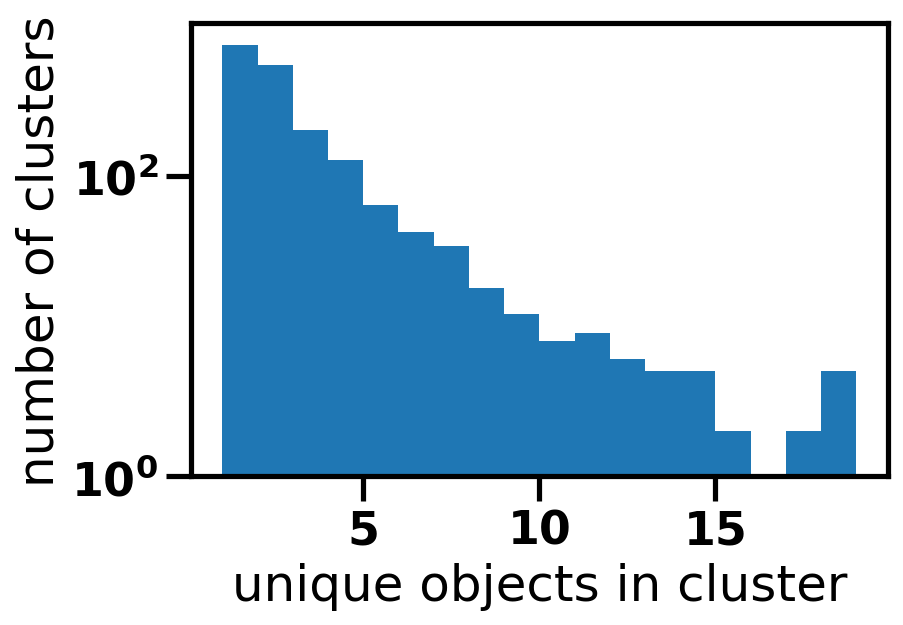

In [550]:
lenof=[len(row) for row in of]

plt.figure(dpi=150)
plt.hist(lenof,bins=range(1,20))
plt.yscale('log')
plt.ylim(1,)
plt.xlabel('unique objects in cluster')
plt.ylabel('number of clusters')


## IOD Filtering (THOR_Gauss)

In [735]:
cof=clustered_observations_final

In [736]:
len(cof.index)

1827

## Perform Filtering

In [911]:
def Filter(dfobs, index, row, rms_max=27):
    """Filter clusters of observations via Initial Orbit Determination
    
    Parameters:
    -----------
    dfobs   ... Pandas DataFrame containing obsId, epoch an RA DEC values for all observations
    index   ... Pandas index / clusterId
    row     ... Pandas row containing obsIds in the respective cluster with index index
    rms_max ... RMS O-C cutoff for filter
    
    Returns:
    --------
    index    ... Pandas index / clusterId
    drop_idx ... True/False: does index comply with RMS limit?
    rms      ... The actual RMS value for the cluster
    """
    drop_idx=False
    df=dfobs[dfobs['obsId'].isin(row['obsId'])]
    rms = -999
    try:
        [rms,epoch,orbit] = ls.iodFilter(df)
        print('r, rdot', row.r,row.drdt)
        print('rms', rms)
        if(rms>rms_max):
            drop_idx=True
    except:
        #print('IOD failed')
        drop_idx=True
    return index, drop_idx, rms

In [912]:
# Calculate RMS O-C using Gauss IOD orbit propagated to the epochs of observations.

#batchsize=np.rint(len(cof.index)/nproc).astype(int)+1
drop_idx=Parallel(n_jobs=10, batch_size='auto')(delayed(Filter)
                                                (dfobs, index, row) for index, row in cof.iterrows())        

In [922]:
# Filter all indices with RMS > RMS_limit
drop_idx2=np.array(drop_idx)
drop_idx3=drop_idx2[drop_idx2[:,1]==1][:,0]
cof2=cof.drop(index=drop_idx3)

In [923]:
cof2

,clusterId,obsId,r,drdt,cluster_epoch
449,12,"[10366, 11258, 17209, 18025, 22667, 24160]",2.0,-0.06,52397.573056
479,6,"[7885, 10402, 14939, 17247, 18095, 29926, 31336]",2.0,-0.05,52397.573056
480,9,"[10382, 11286, 17224, 18052, 22719, 24190]",2.0,-0.05,52397.573056
495,181,"[21327, 28383, 32556, 39442, 53979, 66220]",2.0,-0.05,52397.573056
510,43,"[25117, 32290, 34985, 35857, 36757, 56615, 624...",2.0,-0.03,52397.573056
...,...,...,...,...,...
1789,12,"[171, 2560, 3480, 25533, 32694, 35061, 37130]",3.2,-0.02,52397.573056
1809,2,"[35, 3354, 7237, 7779, 14339, 14840, 25115, 32...",3.3,-0.02,52397.573056
1816,41,"[21235, 25193, 28298, 32371, 36830, 39366, 465...",3.4,-0.03,52397.573056
1818,0,"[132, 2550, 3441, 5906, 7937, 14989, 56797, 70...",3.4,-0.02,52397.573056


In [924]:
[cof3, subset_clusters, subset_cluster_ids]=collapseClusterSubsets(cof2)

In [925]:
cof3

,clusterId,obsId,r,drdt,cluster_epoch
0,12,"[10366, 11258, 17209, 18025, 22667, 24160]",2.0,-0.06,52397.573056
1,6,"[7885, 10402, 14939, 17247, 18095, 29926, 31336]",2.0,-0.05,52397.573056
2,9,"[10382, 11286, 17224, 18052, 22719, 24190]",2.0,-0.05,52397.573056
3,181,"[21327, 28383, 32556, 39442, 53979, 66220]",2.0,-0.05,52397.573056
4,43,"[25117, 32290, 34985, 35857, 36757, 56615, 624...",2.0,-0.03,52397.573056
...,...,...,...,...,...
65,12,"[171, 2560, 3480, 25533, 32694, 35061, 37130]",3.2,-0.02,52397.573056
66,2,"[35, 3354, 7237, 7779, 14339, 14840, 25115, 32...",3.3,-0.02,52397.573056
67,41,"[21235, 25193, 28298, 32371, 36830, 39366, 465...",3.4,-0.03,52397.573056
68,0,"[132, 2550, 3441, 5906, 7937, 14989, 56797, 70...",3.4,-0.02,52397.573056


In [926]:
[idx, objects_in_cluster]=objectsInClusters(dfobs, cof3)

In [927]:
number_of_clusters_post_iod=len(objects_in_cluster)
print(number_of_clusters_post_iod)

70


## Purity after IOD [%]

In [928]:
[n_iod_pure, iod_purity, iod_n_noise] = clusterPurity(objects_in_cluster)

In [929]:
len(objects_in_cluster.index)

70

In [934]:
n_iod_pure

51

In [935]:
iod_purity

72.86

In [936]:
iod_n_noise

0

## Completness wrt MOPS [%]

In [939]:
number_of_clusters_post_iod/n_mops*100

280.0

## Objects findable by MOPS

In [940]:
objId_mops

array(['S100aS6Pa', 'S1000mS6a', 'S100axLHa', 'S1001wbta', 'S100azRha',
       'S100EmvQa', 'S1000sTba', 'S100ev1Ga', 'S100bfeLa', 'S100oZzSa',
       'S10067eIa', 'S1004iyka', 'S100n4Cja', 'S1002KYPa', 'S100fzEfa',
       'S100rYpKa', 'S100dJWva', 'S1005DaLa', 'S100ciULa', 'S100fxv5a',
       'S1002eHEa', 'S1003kfZa', 'S100c9GBa', 'S100dIGPa', 'S1008DVTa'],
      dtype=object)

# Objects found by HelioLinC2


In [941]:
objects_in_cluster['objId']

0                [S100gYava]
1                [S1002fLca]
2                [S100iRMYa]
3     [S100nIOOa, S100xaQea]
4     [S100hXcga, S100JFrda]
               ...          
65               [S100nsOYa]
66               [S1000mS6a]
67               [S100eMsia]
68               [S1000h0Na]
69               [S10066ywa]
Name: objId, Length: 70, dtype: object

## Objects findable by both HelioLinC2 and MOPS

In [942]:
list(set(objects_found) & set(objId_mops))

['S1000mS6a', 'S100ev1Ga', 'S100dIGPa', 'S100rYpKa', 'S1001wbta', 'S1000sTba']